### Imports:

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from PIL import Image
import os
from tqdm import tqdm

import cv2
import skimage

from scipy.ndimage import binary_fill_holes
from skimage import img_as_ubyte
from skimage.color import rgb2gray, rgb2hsv
from skimage.exposure import equalize_hist, histogram
from skimage.feature import canny
from skimage.filters import threshold_otsu, unsharp_mask, gaussian
from skimage.measure import find_contours, approximate_polygon
from skimage.morphology import (dilation, erosion, binary_closing, binary_opening, remove_small_holes,
                                remove_small_objects, thin, convex_hull_image, square, disk, diamond, octagon, star, skeletonize)
from skimage.util import invert

from scipy.signal import argrelmin, argrelmax, argrelextrema
from scipy.signal import find_peaks, find_peaks_cwt
from scipy.spatial import distance_matrix

### Basic functions:

In [2]:
def to_bin_uint8(img):
    return img.astype(np.uint8) * 255

In [3]:
def list_get(list_, ind_, default_):
  try:
    return list_[ind_]
  except IndexError:
    return default_

def show_images(img_arr, name_arr=[], n_in_row=3, factor_r=8, factor_c=8, figsize=None,
         title=None, cmap_='Greys', label_fontsize=12, tick_fontsize=11, save_path=None):
    if type(img_arr) is np.ndarray:
        quant = img_arr.shape[0]
    elif type(img_arr) is list:
        quant = len(img_arr)
    cols = min(quant, n_in_row)
    rows = quant // n_in_row + (1 if quant % n_in_row else 0)
    if figsize is None:
        figsize = (int(factor_c * cols), int(factor_r * rows))
    fig = plt.figure(figsize=figsize)
    if title is not None:
        fig.suptitle(title, fontsize=14, y = 0.88)
    for i, img in enumerate(img_arr):
        ax = fig.add_subplot(rows, cols, i + 1)
        if type(img) is tuple:
            x, y = img
            ax.plot(x, y)
            ax.set_xlabel(list_get(name_arr, i, ''), fontsize=label_fontsize)
        else:
            ax.imshow(img, cmap=cmap_)
#             print(name_arr[i], len(img_arr), len(name_arr))
            ax.set_xlabel(list_get(name_arr, i, ''), fontsize=label_fontsize)
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            ax.xaxis.set_ticks_position('top')
            ax.tick_params(axis='both', labelsize=tick_fontsize)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(f'{save_path}')
    plt.show()

### Solution:

In [4]:
def crop_palm(mask, center, radius, centroid):
    chk_x, chk_y = True, True
    
    x_o, y_o = center
    x_c, y_c = centroid
    alpha, beta = None, None
    
    if x_o - x_c == 0:
        chk_x = False
    if y_o - y_c == 0:
        chk_y = False
    
    if not chk_x and not chk_y:
        assert 0 == 1
    elif not chk_x:
        alpha = 1
        beta = 1
    else:
        alpha = (y_o - y_c) / (x_o - x_c)
        beta = np.sqrt(1 + alpha**2)
    
    w_arr = np.vstack([np.array([x_o + chk_x * (radius / beta),
                                 y_o + alpha * radius / beta]),
                       np.array([x_o - chk_x * (radius / beta),
                                 y_o - alpha * radius / beta])])
    c_arr = np.vstack([np.array([x_c, y_c]),np.array([x_c, y_c])])

    ind = np.argmax(np.sqrt(np.sum((w_arr - c_arr)**2, axis=1)))
    x_w, y_w = wrist = w_arr[ind].astype(np.int)

    bound_points = np.array([[0, 0], img.shape[:2][::-1]])
    
    p1 = np.copy(bound_points[0])
    p2 = np.copy(bound_points[1])
    if not chk_y:
        p1[0] = wrist[0]
        p2[0] = wrist[0]
    elif not chk_x:
        p1[1] = wrist[1]
        p2[1] = wrist[1]    
    else:
        f = lambda x: y_w - (x - x_w) / alpha
        p1[1] = f(p1[0])
        p2[1] = f(p2[0])
        
    p3 = np.copy(p2)
    p4 = np.copy(p1)
    if not chk_y:
        ind = 1 if x_c < wrist[0] else 0
        p3[0] = bound_points[ind][0]
        p4[0] = bound_points[ind][0]
    elif not chk_x:
        ind = 1 if y_c < wrist[1] else 0
        p3[1] = bound_points[ind][1]
        p4[1] = bound_points[ind][1]
    else:
        ind = 1 if y_c < f(x_c) else 0
        p3[1] = bound_points[ind][1]
        p4[1] = bound_points[ind][1]
        
    coords = [np.array([p1, p2, p3, p4])]
    cv2.fillPoly(mask, coords, color=(0, 0, 0))

    return wrist, coords

### Input

In [5]:
input_folder = 'Training'

src_images = []
src_names = os.listdir(input_folder)
for name in tqdm(src_names):
    img = cv2.imread(f'{input_folder}/{name}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    src_images.append(np.array(img))

100%|█████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 330.46it/s]


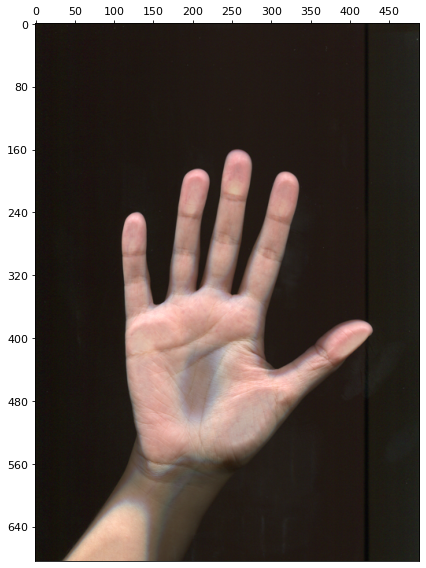

In [6]:
img = np.copy(src_images[0])

show_images([img])

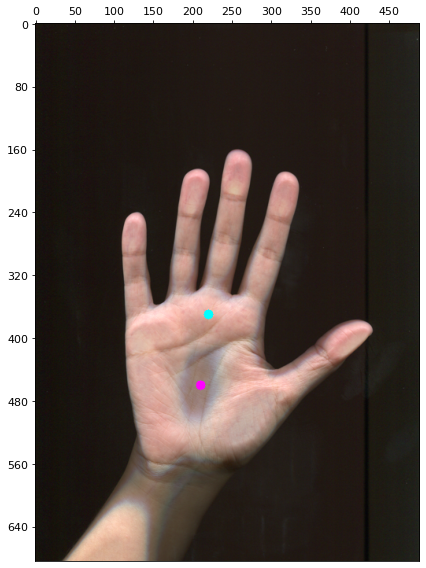

In [7]:
img2 = np.copy(img)

# for OpenCV format: rows of image (vertically) is OY, cols of image (horizontally) is OX
center = np.array([210, 460])
centroid = np.array([220, 370])

cv2.circle(img2, tuple(center), 6, (255, 0, 255), -1)
cv2.circle(img2, tuple(centroid), 6, (0, 255, 255), -1)

show_images([img2])

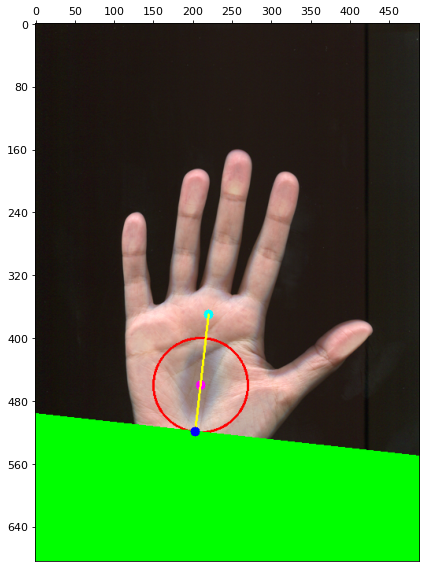

In [11]:
img3 = np.copy(img)

center = np.array([210, 460])
radius = 60 # radius around center
centroid = np.array([220, 370])

# Что мы имеем
cv2.circle(img3, tuple(center), 6, (255, 0, 255), -1)
cv2.circle(img3, tuple(centroid), 6, (0, 255, 255), -1)
cv2.circle(img3, tuple(center), radius, (255, 0, 0), 2)

wrist, removed_coords = crop_palm(img3, center, radius, centroid)
# crop_palm автоматически отрежет чёрным цветом ненужную область у первого аргумента.
# Там должна быть маска, но мы туда и обычное изображение отправить можем. Сейчас это просто для наглядности.

# Мало того, что crop_palm залил 4-к removed_coords чёрным цветом:
# опять же для наглядности мы зальём его на изображении цветом
cv2.fillPoly(img3, removed_coords, color=(0, 255, 0))

# Получили точку запястья - проведём линию от центроида до неё (эта линия по пути пересечёт и центр)
cv2.line(img3, tuple(centroid), tuple(wrist), (255, 255, 0), 2)

# Сама точка запястья
cv2.circle(img3, tuple(wrist), 6, (0, 0, 255), -1)

show_images([img3])